In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.stats import norm, lognorm, qmc # gives us the normal and log normal pdf,cdf and inverse cdf (ppf,point percent function)
from scipy.stats.mstats import gmean #geomeetric mean


## 1. Call and put option

Let S(0) = 100, r = 0.03, T = 1, 𝜎 = 20% and  𝐾 ∈ {70,100, 130}: 

a) Calculate the price using quasi-MC for all strikes 

In [28]:
## Quasi Monte Carlo

def CallPricesQMC(S,n_years,K,r,u):
  paths = S.shape[0]
  C_n_vector = np.zeros(len(K))
  confint_call = np.zeros(len(K))
  for i, k in enumerate(K):
    C = np.exp(-r*n_years) * np.maximum(S[:,-1] - k , 0)
    C_n = np.mean(C)
    C_n_vector[i] = C_n
    confint_call[i] = np.quantile(norm.ppf(u), 0.975)*np.std(C)/(paths ** (1/2))
    #normprint(f"Call option price estimate for strike {k} is: {C_n:.3f} +/- {confint_call[i]}")
  return C_n_vector , confint_call


def PutPricesQMC(S,n_years,K,r,u):
  paths = S.shape[0]
  P_n_vector = np.zeros(len(K))
  confint_put = np.zeros(len(K))
  for i, k in enumerate(K):
    P = np.exp(-r*n_years) * np.maximum(k - S[:,-1] , 0)
    P_n = np.mean(P)
    P_n_vector[i] = P_n
    confint_put[i] = np.quantile(norm.ppf(u), 0.975)*np.std(P)/(paths ** (1/2))
    #normprint(f"Call option price estimate for strike {k} is: {C_n:.3f} +/- {confint_call[i]}")
  return P_n_vector , confint_put

def StockTrajectoryQuasi(n_paths, T, timesteps, S_0,r,sigma,u):
  dt = 1/timesteps
  # Generating stock price paths
  S = S_0 * np.ones((int(n_paths),T+1 ))

  for n in range(int(n_paths)):
      for t in range(1,T+1):
          #print(t,n)
          #S[n,t] =  norm.ppf(u[t,n])
          S[n, t] = S[n,t-1] * np.exp((r-0.5 * sigma ** 2) * dt + np.sqrt(dt) * sigma * norm.ppf(u[n+1,t]))
  return S



In [29]:
# Initiating variables
n_paths = 20000; S_0 = 100; r = 0.03; T = 1; sigma = 0.2; K = np.array([70, 100, 130]); m = 1

# Generating Sobol sequence
sampler = qmc.Sobol(d = 2, scramble = False) # sets number of columns in u
u = sampler.random_base2(17) # sets number of rows in u being 2^argument 

## Generating stock price paths
S = StockTrajectoryQuasi(n_paths, T, m, S_0,r,sigma,u)

## Calculating call prices using S
QMC_call_price, QMC_Confint_call = CallPricesQMC(S,T, K,r,u[1:,0])

## Calculating put prices using S
QMC_put_price, QMC_Confint_put = PutPricesQMC(S,T, K,r,u[1:,0])

print('-----Call prices -------------------------- Estimate ----------------- ')
for i in range(len(K)):
  print(f'  QMC call price including CI for K = {K[i]} is {QMC_call_price[i]}  +/- {QMC_Confint_call[i]}')

print(' ')

print('-----Put prices -------------------------- Estimate ------')
for i in range(len(K)):
  print(f'  QMC put price including CI for K = {K[i]} is {QMC_put_price[i]}  +/- {QMC_Confint_put[i]}')


-----Call prices -------------------------- Estimate ------
  QMC call price including CI for K = 70 is 32.23449379454424  +/- 0.2756352112552673
  QMC call price including CI for K = 100 is 9.411702311000923  +/- 0.19539520537619082
  QMC call price including CI for K = 130 is 1.3560082795051795  +/- 0.07743133555286204
 
-----Put prices -------------------------- Estimate ------
  QMC put price including CI for K = 70 is 0.16533080109865564  +/- 0.016247010160350777
  QMC put price including CI for K = 100 is 6.4559053240105815  +/- 0.12949240106950333
  QMC put price including CI for K = 130 is 27.513577298970084  +/- 0.24074876399189532


b) Calculate the price using importance sampling, but only for K = 130 for the call and K = 70 for the put. Use μ = 
1.84 for the call and μ = -2.26 for the put. 

In [30]:
def StockTrajectory(n_paths, n_years, timesteps, S_0, Z, r, mu = 0):
  X_tilde = Z + mu
  dt = n_years/timesteps
  S = S_0 * np.ones((int(n_paths),n_years * timesteps +1))
  for n in range(int(n_paths)):
    for t in range(1,Z.shape[1]):
      S[n, t] = S[n,t-1] * np.exp((r-0.5 * sigma ** 2) * dt + np.sqrt(dt) * sigma * X_tilde[n,t])
  return S

def LikelihoodRatio( Z, mu=0):
  X_tilde = Z + mu
  LR = np.exp(-mu * X_tilde + 0.5 * (mu ** 2))
  return LR

def CalculateCallIS(S,K,r, LR):
  paths = S.shape[0]
  n_years = S.shape[1] - 1
  C_n_vector = np.zeros(len(K))
  confint_call = np.zeros(len(K))
  for i, k in enumerate(K):
    H = np.exp(-r*n_years) * np.maximum(S[:,-1] - k , 0) 
    C = H * LR[:,-1]
    C_n_vector[i] = np.mean(C)
    confint_call[i] = np.quantile(Z, 0.975)*np.std(C)/(paths ** (1/2))
    #print(f"Call option price estimate for strike {k} is: {C_n:.3f} +/- {confint_call[i]}")
  return C_n_vector, confint_call

def CalculatePutIS(S,K,r, LR):
  paths = S.shape[0]
  n_years = S.shape[1] - 1
  C_n_vector = np.zeros(len(K))
  confint_call = np.zeros(len(K))
  for i, k in enumerate(K):
    H = np.exp(-r*n_years) * np.maximum(k - S[:,-1]  , 0) 
    C = H * LR[:,-1]
    C_n_vector[i] = np.mean(C)
    confint_call[i] = np.quantile(Z, 0.975)*np.std(C)/(paths ** (1/2))
    #print(f"Call option price estimate for strike {k} is: {C_n:.3f} +/- {confint_call[i]}")
  return C_n_vector, confint_call


In [31]:
# # Importance sampling for all strikes , call and put
K = np.array([ 70,100,130]); mu = np.array([1.84, -2.26]); simulations = 20000
m = 1

Z = np.random.standard_normal((simulations, T + 1))

S_call = StockTrajectory(simulations, T, m, S_0, Z,r,mu[0]) 
S_put = StockTrajectory(simulations, T, m, S_0, Z,r,mu[1]) 

LR_call = LikelihoodRatio(Z,mu[0])
LR_put = LikelihoodRatio(Z,mu[1])

CallPrice_IS , Confint_call_IS = CalculateCallIS(S_call,K,r, LR_call)
PutPrice_IS, Confint_put_IS  = CalculatePutIS(S_put,K,r, LR_put)

In [32]:
# Prices including confidence bounds
IS_Callintervals = [[np.round((CallPrice_IS[i] - Confint_call_IS[i]),3) , np.round(CallPrice_IS[i],3), np.round((CallPrice_IS[i] + Confint_call_IS[i]),3) ] for i in range(len(CallPrice_IS)) ]
#AV_Callintervals = [[np.round((AV_Call_Prices[i] - AV_Call_CI[i]),3) , np.round(AV_Call_Prices[i],3), np.round((AV_Call_Prices[i] + AV_Call_CI[i]),3) ] for i in range(len(AV_Call_Prices)) ]

print('-----Call prices -------------------------- Lower Estimate Upper------')
for i in range(len(K)):
  print(f'  IS call price including CI for K = {K[i]} is {IS_Callintervals[i]}')
  #print(f'  AV  call price including CI for K = {K[i]} is {AV_Callintervals[i] }')

print(' ')

SMC_Putintervals = [[np.round((PutPrice_IS[i] - Confint_put_IS[i]),3) , np.round(PutPrice_IS[i],3), np.round((PutPrice_IS[i] + Confint_put_IS[i]),3) ] for i in range(len(CallPrice_IS)) ]
#AV_Putintervals = [[np.round((AV_Put_Prices[i] - AV_Put_CI[i]),3) , np.round(AV_Put_Prices[i],3), np.round((AV_Put_Prices[i] + AV_Put_CI[i]),3) ] for i in range(len(AV_Put_Prices)) ]

print('-----Put prices --------------------------- Lower Estimate Upper----')
for i in range(len(K)):
  print(f'  IS put price including CI for K = {K[i]} is {SMC_Putintervals[i]}')
  #print(f'  AV  put price including CI for K = {K[i]} is {AV_Putintervals[i] }')
print('----------------------------------------------------------------------- ')

-----Call prices -------------------------- Lower Estimate Upper------
  IS call price including CI for K = 70 is [31.665, 32.408, 33.151]
  IS call price including CI for K = 100 is [9.255, 9.358, 9.461]
  IS call price including CI for K = 130 is [1.345, 1.36, 1.375]
 
-----Put prices --------------------------- Lower Estimate Upper----
  IS put price including CI for K = 70 is [0.164, 0.167, 0.169]
  IS put price including CI for K = 100 is [6.286, 6.406, 6.526]
  IS put price including CI for K = 130 is [26.728, 27.786, 28.843]
----------------------------------------------------------------------- 


c) Produce a comparison plot including the methods (and the exact price) from assignment 1 for the call with K = 
130.

In [34]:
def AntitheticCall(S_plus, S_minus,n_years,K,r,paths):
  C_av_vector = np.zeros(len(K))
  confint_call_av = np.zeros(len(K))
  for i, k in enumerate(K):
    C_plus = np.exp(-r*n_years) * np.maximum(S_plus[:,-1] - k , 0)
    C_minus = np.exp(-r*n_years) * np.maximum(S_minus[:,-1] - k , 0)
    C_hat = (C_plus + C_minus)/2
    C_av = np.mean(C_hat)
    C_av_vector[i] = C_av
    confint_call_av[i] = np.quantile(Z, 0.975)*np.std(C_hat)/(paths ** (1/2))
    #print(f"Call option price estimate for strike {k} is: {C_av:.3f} +/- {confint_call_av[i]}")
  return C_av_vector, confint_call_av

def AntitheticPut(S_plus, S_minus,n_years,K,r,paths):
  P_av_vector = np.zeros(len(K))
  confint_put_av = np.zeros(len(K))
  for i, k in enumerate(K):
    P_plus = np.exp(-r*n_years) * np.maximum(k-S_plus[:,-1] , 0)
    P_minus = np.exp(-r*n_years) * np.maximum(k-S_minus[:,-1] , 0)
    P_hat = (P_plus + P_minus)/2
    P_av = np.mean(P_hat)
    P_av_vector[i] = P_av
    confint_put_av[i] = np.quantile(Z, 0.975)*np.std(P_hat)/(paths ** (1/2))
    #print(f"Put option price estimate for strike {k} is: {P_av:.3f} +/- {confint_put_av[i]}")
  return P_av_vector, confint_put_av

def CalculateCallPrices(S,n_years,K,r,paths):
  C_n_vector = np.zeros(len(K))
  confint_call = np.zeros(len(K))
  for i, k in enumerate(K):
    C = np.exp(-r*n_years) * np.maximum(S[:,-1] - k , 0)
    C_n = np.mean(C)
    C_n_vector[i] = C_n
    confint_call[i] = np.quantile(Z, 0.975)*np.std(C)/(paths ** (1/2))
    #print(f"Call option price estimate for strike {k} is: {C_n:.3f} +/- {confint_call[i]}")
  return C_n_vector, confint_call

def CalculatePutPrices(S,n_years,K,r,paths):
  P_n_vector = np.zeros(len(K))
  confint_put = np.zeros(len(K))
  for i, k in enumerate(K):
    P = np.exp(-r*n_years) * np.maximum(k-S[:,-1] , 0)
    P_n = np.mean(P)
    P_n_vector[i] = P_n
    confint_put[i] = np.quantile(Z, 0.975)*np.std(P) /(paths ** (1/2))
    #print(f"Put option price estimate for strike {k} is: {P_n:.3f} +/- {confint_put[i]} ")
  return P_n_vector, confint_put

def BlackScholes(S, T, K, sigma,r):
  d1 = 1/(sigma*(T ** (1/2)))* (np.log(S/K) + (r + (sigma ** 2) / 2 ) * T )
  d2 = d1 - sigma * T ** (1/2)
  price = S * norm.cdf(d1) - np.exp(-r*T) * norm.cdf(d2) *K
  return price

def PutCallParity(CallPrice,T , r, S, K ):
  # Take Call pricces and calculate the put prices
  p = CallPrice - S + K * np.exp(-r * T)
  return p


In [35]:
# # BS price of the options
S_0 = 100 ; r = 0.03 ; T = 1 ; sigma = 0.2; K = [70,100,130]

CallPrices = [BlackScholes(S_0, T, k, sigma,r) for k in K]

for i, p in enumerate(CallPrices):
  print(f"Call option price at strike {K[i]} is:  {p.round(3)}")

print(' ')
PutPrices = [PutCallParity(CallPrices[i], T, r, S_0, k) for i, k in enumerate(K)]
for i, p in enumerate(PutPrices):
  print(f"Put option price at strike {K[i]} is:  {p.round(3)}")

Call option price at strike 70 is:  32.235
Call option price at strike 100 is:  9.413
Call option price at strike 130 is:  1.358
 
Put option price at strike 70 is:  0.166
Put option price at strike 100 is:  6.458
Put option price at strike 130 is:  27.516


In [43]:
S_0 = 100
n_years = 1
timesteps = 1
n_paths = np.linspace(10000,100000,10)
K = np.array([70, 100, 130])
mu = np.array([1.84, -2.26])


# Generating Sobol sequence
sampler = qmc.Sobol(d = 2, scramble = False) # sets number of columns in u
u = sampler.random_base2(17) # sets number of rows in u being 2^argument 

# Define arrays
SMC_Call = np.zeros((len(n_paths),len(K)))
AV_Call = np.zeros((len(n_paths),len(K)))
SMC_Put = np.zeros((len(n_paths),len(K)))
AV_Put = np.zeros((len(n_paths),len(K)))
IS_Call = np.zeros((len(n_paths),len(K)))
IS_Put = np.zeros((len(n_paths),len(K)))

QMC_Call = np.zeros((len(n_paths),len(K)))
QMC_Put = np.zeros((len(n_paths),len(K)))
QMC_Call_CI = np.zeros((len(n_paths),len(K)))
QMC_Put_CI = np.zeros((len(n_paths),len(K)))

SMC_Call_CI_vec = np.zeros((len(n_paths),len(K)))
AV_Call_CI_vec = np.zeros((len(n_paths),len(K)))
SMC_Put_CI_vec = np.zeros((len(n_paths),len(K)))
AV_Put_CI_vec = np.zeros((len(n_paths),len(K)))

IS_Call_CI_vec = np.zeros((len(n_paths),len(K)))
IS_Put_CI_vec = np.zeros((len(n_paths),len(K)))

for i, sims in enumerate(n_paths):
  paths = int(sims);
  Z = np.random.standard_normal((int(paths),n_years+1))
  #### SMC
  S = StockTrajectory(paths, n_years, timesteps, S_0, Z, r)
  SMC_Call_price, SMC_Call_CI = CalculateCallPrices(S,n_years,K,r,paths)
  SMC_Put_price, SMC_Put_CI = CalculatePutPrices(S,n_years,K,r,paths)

  #### AV
  S_plus = StockTrajectory(paths, n_years, timesteps, S_0, Z, r)
  S_minus = StockTrajectory(paths, n_years, timesteps, S_0, -Z, r)
  AV_Call_price, AV_Call_CI = AntitheticCall(S_plus, S_minus,n_years,K,r,paths)
  AV_Put_price, AV_Put_CI = AntitheticPut(S_plus, S_minus,n_years,K,r,paths)

  #### IS

  S_call = StockTrajectory(paths, T, m, S_0, Z,r,mu[0]) 
  S_put = StockTrajectory(paths, T, m, S_0, Z,r,mu[1]) 

  LR_call = LikelihoodRatio(Z,mu[0])
  LR_put = LikelihoodRatio(Z,mu[1])

  CallPrice_IS , Confint_call_IS = CalculateCallIS(S_call,K,r, LR_call)
  PutPrice_IS, Confint_put_IS  = CalculatePutIS(S_put,K,r, LR_put)

  #### QMC 

  ## Generating stock price paths
  S = StockTrajectoryQuasi(paths, T, m, S_0,r,sigma,u)

  ## Calculating QMC prices using S
  QMC_call_price, QMC_Confint_call = CallPricesQMC(S,T, K,r,u[1:,0])
  QMC_put_price, QMC_Confint_put = PutPricesQMC(S,T, K,r,u[1:,0])


  for j in range(len(K)):
    SMC_Call[i,j] = SMC_Call_price[j]
    SMC_Put[i,j] = SMC_Put_price[j]
    AV_Call[i,j] = AV_Call_price[j]
    AV_Put[i,j] = AV_Put_price[j]
    IS_Call[i,j] = CallPrice_IS[j]
    IS_Put[i,j] = PutPrice_IS[j]

    SMC_Call_CI_vec[i,j] = SMC_Call_CI[j]
    SMC_Put_CI_vec[i,j] = SMC_Put_CI[j]
    AV_Call_CI_vec[i,j] = AV_Call_CI[j]
    AV_Put_CI_vec[i,j] = AV_Put_CI[j]
    IS_Call_CI_vec[i,j] = Confint_call_IS[j]
    IS_Put_CI_vec[i,j] = Confint_put_IS[j]

    QMC_Call[i,j] =  QMC_call_price[j]
    QMC_Put[i,j] = QMC_put_price[j]
    QMC_Call_CI[i,j] = Confint_call_IS[j]
    QMC_Put_CI[i,j] = Confint_put_IS[j]

    



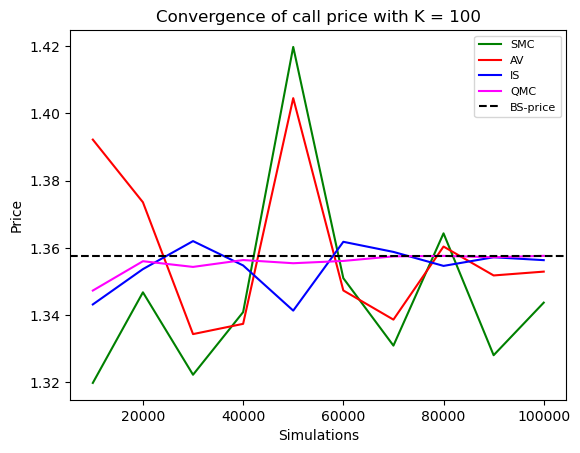

In [45]:
# Plot call
# SMC (uncomment lines for confidence intervals)
plt.plot(n_paths,SMC_Call[:,2], label='SMC',color = 'green');
# plt.plot(n_paths,SMC_Call[:,1]+ SMC_Call_CI_vec[:,1], label='SMC upper bound', linestyle='--',color = 'green',linewidth=0.3);
# plt.plot(n_paths,SMC_Call[:,1]- SMC_Call_CI_vec[:,1], label='SMC lower bound', linestyle='--',color = 'green',linewidth=0.3);

# AV (uncomment lines for confidence intervals)
plt.plot(n_paths,AV_Call[:,2], label='AV',color = 'red');
# plt.plot(n_paths,AV_Call[:,1]+ AV_Call_CI_vec[:,1], label='AV upper bound', linestyle='--',color = 'red',linewidth=0.3);
# plt.plot(n_paths,AV_Call[:,1]- AV_Call_CI_vec[:,1], label='AV lower bound', linestyle='--',color = 'red',linewidth=0.3);

# IS (uncomment lines for confidence intervals)
plt.plot(n_paths,IS_Call[:,2], label='IS',color = 'blue');
# plt.plot(n_paths,IS_Call[:,1]+ IS_Call_CI_vec[:,1], label='IS upper bound', linestyle='--',color = 'blue',linewidth=0.3);
# plt.plot(n_paths,IS_Call[:,1]- IS_Call_CI_vec[:,1], label='IS lower bound', linestyle='--',color = 'blue',linewidth=0.3);

# IS (uncomment lines for confidence intervals)
plt.plot(n_paths,QMC_Call[:,2], label='QMC',color = 'magenta');
#plt.plot(n_paths,QMC_Call[:,1]+ QMC_Call_CI_vec[:,1], label='QMC upper bound', linestyle='--',color = 'blue',linewidth=0.3);
#plt.plot(n_paths,QMC_Call[:,1]- QMC_Call_CI_vec[:,1], label='QMC lower bound', linestyle='--',color = 'blue',linewidth=0.3);


# BS
plt.axhline(y=CallPrices[2], color='k', linestyle='--', label='BS-price');

# Styling
plt.xlabel('Simulations')
plt.ylabel('Price')
plt.title('Convergence of call price with K = 100')
plt.legend(fontsize=8);

Discussion: Based on the plot in c) which pricing method seems to be the most accurate? 

## 2. Asian call

Choose parameters as in problem 1 with $0 = 𝑡_0 < 𝑡_1 < ⋯ < 𝑡_𝑚 = 𝑇,  𝑡_𝑖 − 𝑡_𝑖−1 = \frac{1}{𝑚}$ and consider an Asian call on 
arithmetic mean. 

a) Calculate the price using quasi-MC for all strikes 𝐾 ∈ {70,100,130} and 𝑚 ∈ {12, 52} 

In [103]:
def StockTrajectoryQuasi(n_paths, T, timesteps, S_0,r,sigma,u):
  dt = 1/timesteps
  # Generating stock price paths
  S = S_0 * np.ones((int(n_paths),T*timesteps+1))

  for n in range(int(n_paths)):
      for t in range(1,T*timesteps+1):
          #print(t,n)
          #S[n,t] =  norm.ppf(u[t,n])
          S[n, t] = S[n,t-1] * np.exp((r-0.5 * sigma ** 2) * dt + np.sqrt(dt) * sigma * norm.ppf(u[n+1,t]))
  return S

def AsianAritmetricPayoff(S,K,n_years,r):
  simulations = S.shape[0] # Number of rows
  row_length = S.shape[1]  # Row length
  payoff = np.zeros((simulations,len(K)))
  S_temp = S[:,1:]
  for index, k in enumerate(K):
    S_sum = np.sum(S_temp, axis = 1) # Rowise sum of the prices
    payoff[:,index] =  np.exp(-r*n_years) * np.maximum((S_sum/(row_length-1)) - k, 0) # Payoff calculation
  return payoff


In [108]:
S_0 = 100; r = 0.03; T = 1; sigma = 0.2; K = np.array([70, 100, 130]); m = np.array([12,52])

paths = 20000

print('Asian call prices ')
for timesteps in m: 
  # Generating Sobol sequence
  sampler = qmc.Sobol(d = timesteps+1, scramble = False) # sets number of columns in u
  u = sampler.random_base2(17) # sets number of rows in u being 2^argument 

  S = StockTrajectoryQuasi(paths, T, timesteps , S_0, r, sigma, u)
  #plt.plot(S.T);

  payoffs = AsianAritmetricPayoff(S,K,T,r) 

  AritmethicPrices = np.mean(payoffs,axis = 0)
  print('-----------------------------------------------------------------------------------------')
  for i, p in enumerate(AritmethicPrices):
    print(f"Arithmetic asian call option price at strike {K[i]} with m = {timesteps}, is:  {p.round(3)}")
                                                                                                                                                                              

Asian call prices 
Arithmetic asian call option price at strike 70 with m = 12, is:  30.702
Arithmetic asian call option price at strike 100 with m = 12, is:  5.636
Arithmetic asian call option price at strike 130 with m = 12, is:  0.122
Arithmetic asian call option price at strike 70 with m = 52, is:  30.599
Arithmetic asian call option price at strike 100 with m = 52, is:  5.349
Arithmetic asian call option price at strike 130 with m = 52, is:  0.092


b) Calculate the price using importance sampling when K = 130. Use $μ = \frac{5}{𝑚}$ in each time step, for 𝑚 ∈ {12, 52}. 

In [111]:
def StockTrajectory(n_paths, n_years, timesteps, S_0, Z, r, mu = 0):
  X_tilde = Z + mu
  dt = n_years/timesteps
  S = S_0 * np.ones((int(n_paths),n_years * timesteps +1 ))

  for n in range(int(n_paths)):
    for t in range(1,Z.shape[1]):
      S[n, t] = S[n,t-1] * np.exp((r-0.5 * sigma ** 2) * dt + np.sqrt(dt) * sigma * X_tilde[n,t])
  return S

def LikelihoodRatio( Z, mu=0):
  X_tilde = Z + mu
  LR = np.exp(-mu * X_tilde + 0.5 * (mu ** 2))
  return LR

def AsianCallIS(S,K,n_years, r, LR):
  paths = S.shape[0]
  C_n_vector = np.zeros(len(K))
  confint_call = np.zeros(len(K))
  for i, k in enumerate(K):
    H = np.exp(-r*n_years) * np.maximum(S[:,-1] - k , 0) 
    C = H * LR[:,-1]
    C_n_vector[i] = np.mean(C)
    confint_call[i] = np.quantile(Z, 0.975)*np.std(C)/(paths ** (1/2))
    #print(f"Call option price estimate for strike {k} is: {C_n:.3f} +/- {confint_call[i]}")
  return C_n_vector#, confint_call

def AsianAritmetricPayoff(S,K,n_years,r,LR):
  simulations = S.shape[0] # Number of rows
  row_length = S.shape[1]  # Row length
  payoff = np.zeros((simulations,len(K)))
  for index, k in enumerate(K):
    S_sum = np.sum(S, axis = 1) # Rowise sum of the prices
    payoff[:,index] =  np.exp(-r*n_years) * np.maximum((S_sum/row_length) - k, 0) # Payoff calculation
  return payoff

In [112]:
S_0 = 100; r = 0.03; T = 1; sigma = 0.2; K = np.array([70, 100, 130]); m = np.array([12,52])

n_paths = 10000

mu = 5/m[0]
Z = np.random.standard_normal((n_paths, T * m[0]+1))
S = StockTrajectory(n_paths, T, m[0], S_0, Z, r, mu)
LR = LikelihoodRatio(Z,mu)

payoff = AsianCallIS(S,K,n_years,r,LR)
prices = np.mean(payoff, axis = 0 )
print(prices)

36.72036788040577


c) Produce a comparison plot including the methods from assignment 1 for K = 130 and m = 5

## 3. Basket call and put option on two underlying stocks  

Let $𝑆_𝑖(0) = 100, 𝜎_𝑖$ = 20 %, r = 0.03, T = 1 and  𝐾 ∈ {70,100,130}. Calculate prices of the basket options using quasi
MC for: 

a)  𝜌 = 0 

b)  𝜌 = 0.5

Method: 

- Generation of random numbers:
    - First, a large matrix of Sobol sequences were generated  
    - Second, a subset of the Sobol matrix was selected to match the number of "simulations" 
    - Third, the value of the normal cumulative density function was evaluated for each of the Sobol values and stored in a matrix Z

- Evaluation of the option prices
    - For each correlation $ \rho = \{ 0, 0.5\}$ and strike $K = \{70, 100, 130 \}$ the following steps were performed.

        - The cholesky matrix A was calculated.

        - Correlated random numbers X were calculated by multiplying A with the matrix Z.

        - The random numbers in X were used to simulate stock prices for two correlated stocks.

        - For the two stocks and each payoff, the call and put payoffs were calculated as described in the task description.

        - The mean values of the payoffs for the call and put was calculated.


In [85]:

def CallPayoff(S,K):
  S1 = S[:,0,:]
  S2 = S[:,1,:]
  res = np.zeros((S1.shape[0],len(K)))
  for index in range(S1.shape[0]):
    for k in range(len(K)):
      res[index,k] = np.maximum((S1[index,-1] + S2[index,-1])/2 - K[k] ,0 )
  return res

def PutPayoff(S,K):
  S1 = S[:,0,:]
  S2 = S[:,1,:]
  res = np.zeros((S1.shape[0],len(K)))
  for index in range(S1.shape[0]):
    for k in range(len(K)):
      res[index,k] = np.maximum(K[k] - (S1[index,-1] + S2[index,-1])/2 ,0 )
  return res

def Cholesky_matrix(stocks, sigma, rho):
  # Function cholesky matrix (stocks, sigma) Return A
  Sigma_matrix = np.zeros([stocks,stocks])
  for i in range(Sigma_matrix.shape[0]):
    for j in range(Sigma_matrix.shape[1]):
      if i == j:
        Sigma_matrix[i,j] = sigma ** 2
      else:
        Sigma_matrix[i,j] = rho * sigma ** 2

  A = np.linalg.cholesky(Sigma_matrix)
  return A

def Stockprices(Z,X,r,sigma,dt,stocks):
  # Function Stockprices(Z,X,r,sigma,dt) Should return S
  S = S_0 * np.ones((Z.shape[0], Z.shape[1], Z.shape[2]+ 1 ))
  for i in range(simulations):
    for j in range(stocks):
      for t in range(1, T+1):
            S[i, j, t] = S[i, j, t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + np.sqrt(dt)  * X[i, j, t-1])
  return S


In [90]:
S_0 = 100; sigma = 0.2; K = np.array([70,100,130]); r = 0.03; T = 1
rho = np.array([0,0.5])
simulations = 20000
dt = 1
stocks = 2

# Generating Sobol sequence
sampler = qmc.Sobol(d = stocks, scramble = False) # sets number of columns in u
u = sampler.random_base2(17) # sets number of rows in u being 2^argument 
Z = np.zeros((simulations, stocks,  T))
u_section = u[1:simulations+1, :]
Z[:,:,0] = norm.ppf(u_section)



print('---------------------------------------------------------------------')
for corr in rho:

  # Create a Cholesky matrix to enable dependence
  A = Cholesky_matrix(stocks, sigma, corr)

  # Generate random number cube where depth is simulations, height is stocks, width is time steps

  X =  A @ Z # Enforcing the dependence structure

  # Create stock price paths
  S = Stockprices(Z,X,r,sigma,dt,stocks)


  Call_payoff_discounted = np.exp(-r * T) * CallPayoff(S,K)
  Put_payoff_discounted = np.exp(-r * T) * PutPayoff(S,K)

  CallPrices = np.mean(Call_payoff_discounted, axis = 0)
  PutPrices = np.mean(Put_payoff_discounted, axis = 0)
  print(f'For correlation = {corr}                     K=70,    K=100,  K=130')
  print(f'   Call prices for the basket option at   {CallPrices[0]:.3f},  {CallPrices[1]:.3f},  {CallPrices[2]:.3f}')
  print(f'   Put  prices for the basket option at   {PutPrices[0]:.3f},   {PutPrices[1]:.3f},  {PutPrices[2]:.3f}')
  print('---------------------------------------------------------------------')



---------------------------------------------------------------------
For correlation = 0.0                     K=70,    K=100,  K=130
   Call prices for the basket option at   32.077,  7.178,  0.340
   Put  prices for the basket option at   0.011,   4.225,  26.500
---------------------------------------------------------------------
For correlation = 0.5                     K=70,    K=100,  K=130
   Call prices for the basket option at   32.129,  8.380,  0.809
   Put  prices for the basket option at   0.063,   5.428,  26.970
---------------------------------------------------------------------


## 4. Barrier option  

Payoff $= 1{𝜏(𝐵) ≤𝑇} ∗ (𝑆(𝑇) − 𝐾)^+$ 𝑤here 𝜏(𝐵) = inf {$𝑡_𝑖:𝑆(𝑡_𝑖) ≤ 𝐵$}. 

Let S(0) = 100, r= 0.03, T = 1, K = 100, 𝜎 ∈ {0.2, 0.4},  𝐵 = 80 and 𝑚 ∈ {12, 52}.

a) Calculate prices assuming the stock follows the Heston model with 𝑃 = 0.1, 𝑏 = σ$^2$, σ$_𝑣$ = 0.1 and for ρ = −0.7 
and ρ = 0.7. Use the squared volatilities above, 𝜎 ∈ {0.2,0.4}, as initial values in the variance process.

In [91]:
def Cholesky_matrix(stocks, sigma, rho):
  # Function cholesky matrix (stocks, sigma) Return A
  Sigma_matrix = np.zeros([stocks,stocks])
  for i in range(Sigma_matrix.shape[0]):
    for j in range(Sigma_matrix.shape[1]):
      if i == j:
        Sigma_matrix[i,j] = sigma ** 2
      else:
        Sigma_matrix[i,j] = rho * sigma ** 2

  A = np.linalg.cholesky(Sigma_matrix)
  return A

def DownInCall(S, b, K):
  # Function that calculates the payoff of the down and in option from stock trajectories
  # and a barrier and strike prices
  res = np.zeros(S.shape[0])
  for row in range(S.shape[0]):
    if np.min(S[row,:]) <= b:
      res[row] = np.maximum(S[row,-1] - K, 0)
  return res


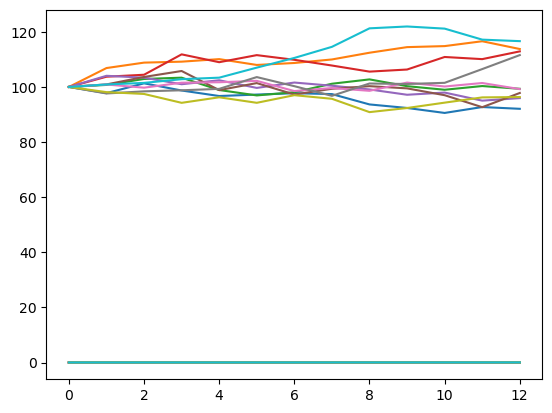

In [98]:
S_0 = 100; r = 0.03; T = 1; K = 100; sigma = np.array([0.2,0.4]);B = 80; m = np.array([12,52])
P = 0.1; sigma_v = 0.1; rho = np.array([-0.7, 0.7]) ; var_0 = sigma ** 2
dims = 2 
m_i = 0
sig_i = 1
rho_i = 1

b = sigma[sig_i] ** 2
dt = 1/m[m_i]

n_paths = 10

## Create correlated random numbers
Z = np.random.standard_normal(( n_paths, dims, int(m[m_i]) + 1))
A = Cholesky_matrix(2,sigma[sig_i],rho[rho_i])
X = A @ Z


## Create Volatility vector
V = sigma[0]**2 * np.ones((n_paths, m[m_i]+1))
for i in range(n_paths):
    for t in range(1,m[m_i]+1 ):
        V[i,t] = V[i,t-1] + P*(b - V[i,t-1]) *dt + sigma_v * np.sqrt(V[i,t-1] *dt)* X[i,1,t]

plt.plot(V.T);


## Creating 
S = S_0 * np.ones((Z.shape[0], Z.shape[2] ))
for i in range(Z.shape[0]):
    for t in range(1, Z.shape[2]):
        S[i, t] = S[i,t-1] + r*S[i,t-1]*dt + np.sqrt(V[i,t] * dt) *S[i,t-1]* X[i,0,t] 

plt.plot(S.T);
#plt.axhline(y=B, color='k', linestyle='--', label='Y = 80');

## Calculating the 
DIC = np.exp(-r*T) * DownInCall(S,B,K)
DIC_n = np.mean(DIC)


# print(f'Price at sigma = {sigma[j]} and {m[k]} timesteps is {DIC_n:.3f}')





b) Calculate prices using importance sampling, as in example 4.6.4 in the book, now assuming a GBM. 

Discussion: For a), which correlation results in higher prices and why?

## 5. Call option on a zero-coupon bond 

Payoff function: 𝜙(𝑝($𝑇_1,𝑇_2$)) = (𝑝($𝑇_1,𝑇_2$) − 𝐾)+. Here 𝑝($𝑇_1,𝑇_2$) denotes the price of a zcb at time $𝑇_1$ with face value 
1 that is paid out at time $𝑇_2$. Let K = 0.8, $𝑇_1$ = 5 and $𝑇_2$ = 10. Assume that the short rate evolves according to Vasiceks 
model (as defined in Glasserman) with parameters r(0) = 0.0137, 𝑃 = 0.2, 𝑏 = 0.02, 𝜎 = 0.01. 

a) Plot the zero-coupon interest rate curve (YTM-curve), at t = 0, given by the parameters in Vasicek’s model. Also 
include the values in a table. Note: You are not asked to plot a path of the short rate.

   Maturity     Yield
0         1  0.714923
1         2  1.329962
2         3  1.870660
3         4  2.347126
4         5  2.768006
5         6  3.140696
6         7  3.471538
7         8  3.765973
8         9  4.028674
9        10  4.263664


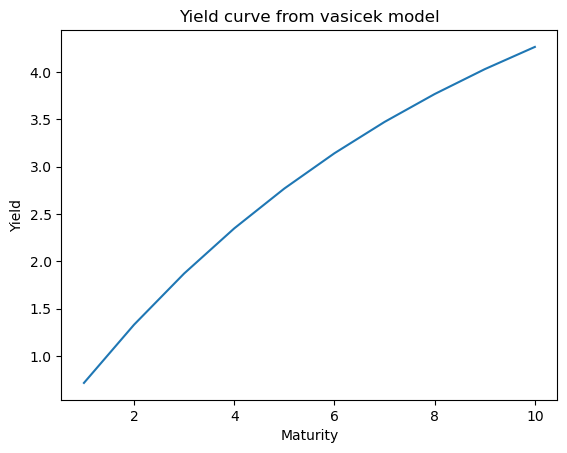

In [69]:
K = 0.8; T_1 = 5; T_2 = 10; r_0 = 0.0137; P = 0.2; b = 0.02; sigma = 0.01
a = P
t = 0
T = np.arange(t+1,11,1)

B = 1/a*(1 - np.exp(-a*(T-t)))
A = (B-(T-t))*(a**2*b-1/2*sigma**2)/(sigma**2) - (sigma**2*B**2)/(4*a)

P = np.exp(A-B*r_0)

Z_T = - (np.log(P)/T)

plt.plot(T,Z_T)
plt.xlabel('Maturity')
plt.ylabel('Yield')
plt.title('Yield curve from vasicek model')

df = pd.DataFrame({
    'Maturity': T,
    'Yield': Z_T
})
print(df)


b) Calculate the price at t = 0 of the option using the exact formula 

In [70]:
K = 0.8; T_1 = 5; T_2 = 10; r_0 = 0.0137; P = 0.2; b = 0.02; sigma = 0.01
a = P
t = 0

def BondPrice(r_0,t,T,a,b,sigma):
    B = 1/a*(1 - np.exp(-a*(T-t)))
    A = ((B-(T-t))*(a**2 * b-1/2*sigma**2)) / (sigma**2) - (sigma**2 * B**2)/(4*a)
    Pr = np.exp(A-B*r_0)
    return Pr


sigma_p = 1/a*(1-np.exp(-a*(T_2-T_1))) * np.sqrt((sigma ** 2) /(2*a) * (1-np.exp(-2*a*(T_1-t))))
d = 1/sigma_p * np.log(BondPrice(r_0,t,T_2,a,b,sigma) / (BondPrice(r_0,t,T_1,a,b,sigma ) *K) )+ sigma_p/2

C = BondPrice(r_0,t,T_2,a,b,sigma)*norm.cdf(d) - BondPrice(r_0,t,T_1,a,b,sigma)*K*norm.cdf(d-sigma_p)








c) Calculate the price at t = 0 of the option using standard MC with a weekly time-step. Use 20 000 simulations.

In [ ]:
Price_T1 = 0.9
T_1 = 5
m = 52; n_paths = 100


Z = np.random.standard_normal((int(n_paths), T_1 * m + 1))








## 6. Adjustable rate mortgage with interest rate ceiling (ARMWIRC) 

Using Vasicek’s model for the short rate, with the same parameters as in the previous problem, calculate the fair 
premium (spread) for a five year ARMWIRC, without amortization, based on the one-month rate and with a ceiling of 
2.3 % (excluding the spread). Use the short rate as the one-month rate.

The fair premium is the spread that makes the market price of the bank’s and the customer’s cash flows equal. 

Use 100 000 simulated paths of the short rate to determine the premium. 